In [2]:
import pandas as pd
import sklearn
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
df = pd.read_parquet('../data/cayzn_train.parquet')

In [38]:
#Selection des variables
# Comme dejà encodé, on ne vas pas utiliser ces features
data = df.drop(columns=["sale_date", "departure_date"])
# On pourra éventuellement laissé de côté "destination_public_holiday" car constamment == 0
data = data.drop(columns=["destination_current_public_holiday"])

In [20]:
## On a observer une plus forte demande en mai (jours férié), juin (également), septembre(rentrée) et decembre (fêtes)
# on peut créer une varaible "haute saison"
data['haute_saison'] = data['sale_day_x'].apply(lambda x: 1 if x in [4, 5, 8, 11] else 0)

# on peut créer une variable qui encode l'arrivée d'un jour férié
data['is_public_holiday_near'] = (
    (data["origin_days_to_next_public_holiday"] <= 10)
)

# on peut regrouper les varaibles Od_number_of_similar_X_hours car elles sont très corrélé
data['total_similar_trains'] = data['od_number_of_similar_2_hours'] + data['od_number_of_similar_4_hours'] + data['od_number_of_similar_12_hours']
data['od_similar_low_density'] = data['total_similar_trains'] <= 8
data['od_similar_medium_density'] = data['total_similar_trains'].between(8, 12, inclusive="right")
## we dont encode the 'high' density to prevent from colinearity

# également créer une feature "is holiday"
data['is_school_holiday'] = (
    (df['origin_current_school_holiday'] == 1) &
    (df['destination_current_school_holiday'] == 1)
)
data.drop(columns=['origin_current_school_holiday', 'destination_current_school_holiday'], inplace=True)


In [21]:
# On encode uniquement les stations, car les date sont déjà encodés

# Creation de la pipeline
stationColumns = ['origin_station_name', 'destination_station_name']
allStations = pd.concat([data[stationColumns[0]], data[stationColumns[1]]])
stationEncoder = (sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(pd.DataFrame(allStations)))

numericalColumns = data.drop(columns=["demand"]).select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = sklearn.compose.ColumnTransformer(
    transformers = [
        ('originEncoder', stationEncoder, [stationColumns[0]]),
        ('destinationEncoder', stationEncoder, [stationColumns[1]]),
        ('standardscaler', sklearn.preprocessing.StandardScaler(), numericalColumns)
    ],
    remainder="passthrough"
)

LightGBMpipeline = sklearn.pipeline.Pipeline( ## pertinent pour sa capacité à gérer les données données en très gros volumes, pas nécessaire de faire de la réduction de dimension car déjà le but de l'algo
    steps= [
        ('preprocessing', preprocessor),
        ('regressor', LGBMRegressor(random_state=0))
    ]
)

In [22]:
y = data.demand
X = data.drop(columns=["demand"])

In [23]:
lgbm_search = GridSearchCV(LightGBMpipeline, {}, cv=10, n_jobs=-1, verbose=1)

# Fit on your data (replace df and target column as needed)

lgbm_search.fit(X, y)

print("LightGBM best RMSE:", lgbm_search.best_score_)
print("LightGBM best params:", lgbm_search.best_params_)



Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 632841, number of used features: 38
[LightGBM] [Info] Start training from score 3.000149
LightGBM best RMSE: 0.7498952493663464
LightGBM best params: {}


In [39]:
## prediction on the test value
test_data = pd.read_parquet('../data/cayzn_test.parquet')

test_sale_dates = pd.to_datetime(test_data['sale_date'])
test_data = test_data.drop(columns=["sale_date", "departure_date"])
test_data = test_data.drop(columns=["destination_current_public_holiday"])

test_data['haute_saison'] = test_data['sale_day_x'].apply(lambda x: 1 if x in [4, 5, 8, 11] else 0)
test_data['is_public_holiday_near'] = (
    (test_data["origin_days_to_next_public_holiday"] <= 10)
)
test_data['total_similar_trains'] = test_data['od_number_of_similar_2_hours'] + test_data['od_number_of_similar_4_hours'] + test_data['od_number_of_similar_12_hours']
test_data['od_similar_low_density'] = test_data['total_similar_trains'] <= 8
test_data['od_similar_medium_density'] = test_data['total_similar_trains'].between(8, 12, inclusive="right")
## on n'encode pas la dernière feature pour éviter la colinéarité
test_data["is_school_holiday"] = (
    (test_data['origin_current_school_holiday'] == 1) &
    (test_data['destination_current_school_holiday'] == 1)
)
test_data.drop(columns=['origin_current_school_holiday', 'destination_current_school_holiday'], inplace=True)


X_test = test_data.drop(columns=["demand"])
y_test = test_data.demand

y_test_pred = lgbm_search.predict(X_test)
test_data['predicted_demand'] = y_test_pred

C:\Users\jules\PycharmProjects\wiremind_2\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [33]:
# Assuming 'y_true', 'y_pred' are arrays with actual and predicted demand
def evaluate_overall(y_true, y_pred, price=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
  
# Example:
evaluate_overall(y_test, y_test_pred)


RMSE: 4.06
MAE: 1.82


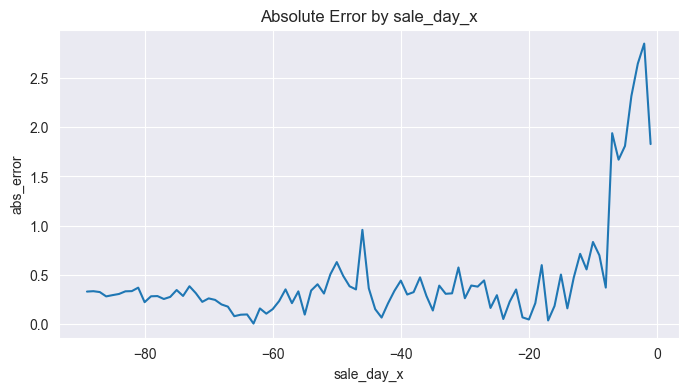

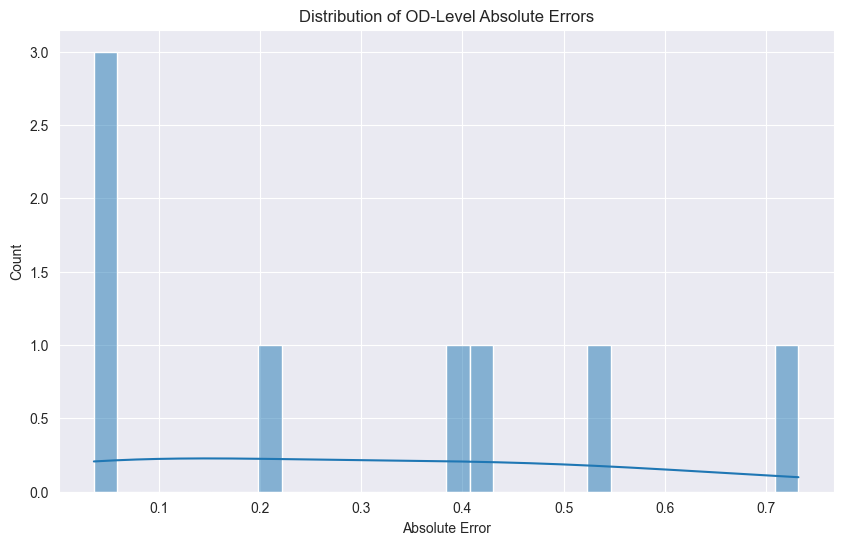

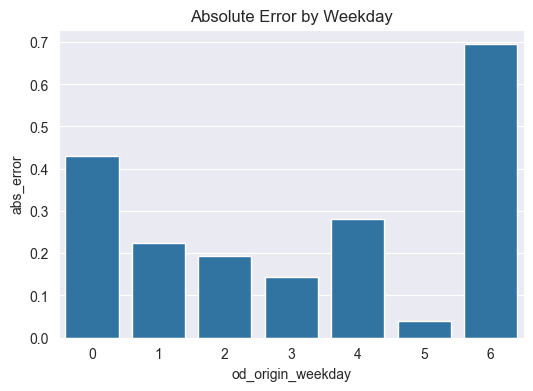

In [34]:
def aggregate_error(df, group_col, y_true='demand', y_pred='predicted_demand'):
    agg = df.groupby(group_col).agg({
        y_true: 'mean',
        y_pred: 'mean'
    }).reset_index()
    
    agg['abs_error'] = np.abs(agg[y_true] - agg[y_pred])
    return agg


day_x_agg = aggregate_error(test_data, 'sale_day_x')

plt.figure(figsize=(8, 4))
sns.lineplot(data=day_x_agg, x='sale_day_x', y='abs_error')
plt.title("Absolute Error by sale_day_x")
plt.show()

od_agg = aggregate_error(test_data, ['origin_station_name', 'destination_station_name'])

plt.figure(figsize=(10, 6))
sns.histplot(od_agg['abs_error'], bins=30, kde=True)
plt.title("Distribution of OD-Level Absolute Errors")
plt.xlabel("Absolute Error")
plt.show()

weekday_agg = aggregate_error(test_data, 'od_origin_weekday')

plt.figure(figsize=(6, 4))
sns.barplot(data=weekday_agg, x='od_origin_weekday', y='abs_error')
plt.title("Absolute Error by Weekday")
plt.show()




C:\Users\jules\AppData\Local\Temp\ipykernel_296620\751737054.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(group_col).agg({


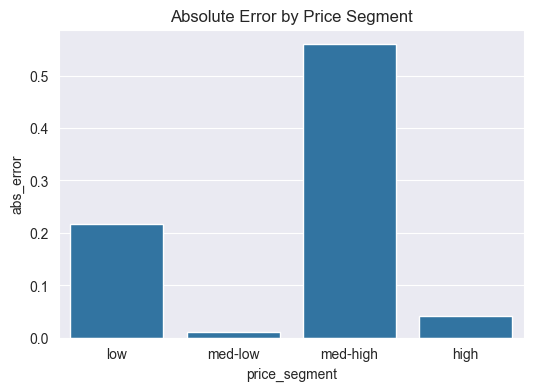

In [35]:
test_data['price_segment'] = pd.qcut(test_data['price'], q=4, labels=['low', 'med-low', 'med-high', 'high'])
price_agg = aggregate_error(test_data, 'price_segment')

plt.figure(figsize=(6, 4))
sns.barplot(data=price_agg, x='price_segment', y='abs_error')
plt.title("Absolute Error by Price Segment")
plt.show()


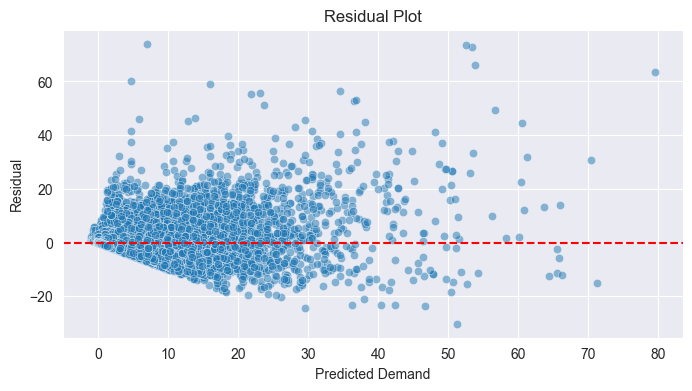

In [36]:
test_data['residual'] = test_data['demand'] - test_data['predicted_demand']

plt.figure(figsize=(8, 4))
sns.scatterplot(data=test_data, x='predicted_demand', y='residual', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Demand")
plt.ylabel("Residual")
plt.show()


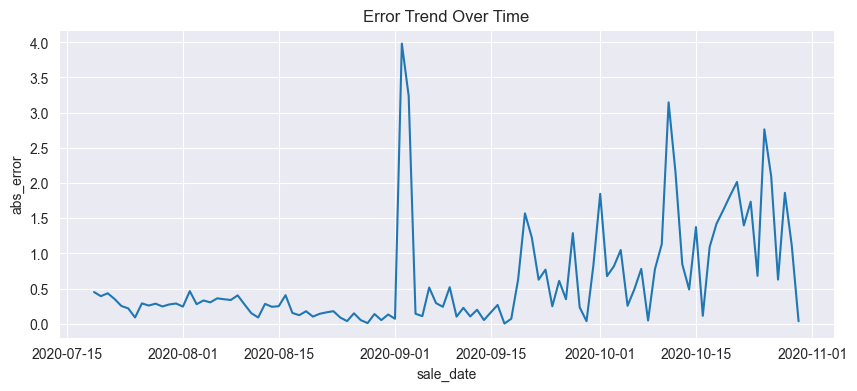

In [40]:
test_data['sale_date'] = pd.to_datetime(test_sale_dates)

time_agg = aggregate_error(test_data, 'sale_date')

plt.figure(figsize=(10, 4))
sns.lineplot(data=time_agg, x='sale_date', y='abs_error')
plt.title("Error Trend Over Time")
plt.show()


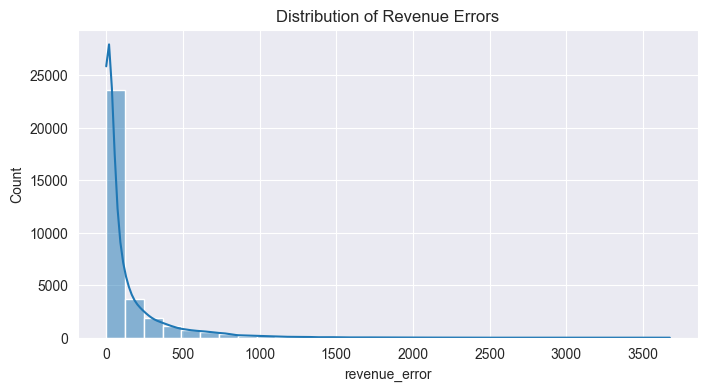

In [42]:
test_data['revenue'] = test_data['price'] * df['demand']
test_data['predicted_revenue'] = test_data['price'] * test_data['predicted_demand']
test_data['revenue_error'] = np.abs(test_data['revenue'] - test_data['predicted_revenue'])

plt.figure(figsize=(8, 4))
sns.histplot(test_data['revenue_error'], bins=30, kde=True)
plt.title("Distribution of Revenue Errors")
plt.show()
